# SBU CSE 352 - HW 1 -  Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

---

Name: [Add your name]

I understand that my submission needs to be my own work: [enter 'yes']

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [3]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [4]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'suck'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [5]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: suck
step 1 - action: west
step 2 - action: suck
step 3 - action: north
step 4 - action: east
step 5 - action: east
step 6 - action: south
step 7 - action: south
step 8 - action: south
step 9 - action: north
step 10 - action: east
step 11 - action: west
step 12 - action: east
step 13 - action: west
step 14 - action: suck
step 15 - action: north
step 16 - action: suck
step 17 - action: east
step 18 - action: suck
step 19 - action: west


5

# Tasks

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design, for example. If it makes your code more simple objects are okay, but try to keep the code as simple as possible.
2. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [6]:

import numpy as np
import random

def print_room(room, pos_x , pos_y , n):
        for i in range(n):
            row = ""
            for j in range(n):
                if (i, j) == (pos_x, pos_y):
                    row += " P "  # robot currenbt position
                elif room[i, j] == "dirty":
                    row += " D "  # dirty tile
                else:
                    row += " . "  # clean tile
            print(row)
        print("\n")

def simulation_environment(agent, n=5, dirt_prob=0.2, max_steps=10, verbose=True):
  #room size n by n with dirt probability of 0.2
  room = np.random.choice(['clean', 'dirty'], size=(n, n), p=[1 - dirt_prob, dirt_prob])
  #initial position
  pos_x , pos_y = random.randint(0, n - 1), random.randint(0, n - 1)
  cost = 0
  '''       N
        00 -> 04
      W 10 -> 14  E

            S       '''
  count = 0
  while 'dirty' in room :

    bumpers = {
        "north" : pos_x == 0,
        "south" : pos_x == n-1,
        "west" :  pos_y == 0,
        "east" :  pos_y == n-1}

    room_status = (room[pos_x, pos_y] == 'dirty')
    action = agent(bumpers, room_status)
    cost+=1
    # follow instructiosn from the agent function if possible
    if action == 'suck' :
      room[pos_x ,pos_y] = 'clean'
    elif action == "north" and not bumpers["north"]:
      pos_x-=1
    elif action == "south" and not bumpers["south"]:
      pos_x+=1
    elif action == "west" and not bumpers["west"]:
      pos_y-=1
    elif action == "east" and not bumpers["east"]:
      pos_y+=1
    '''
    if verbose:
      print(f"Step {cost}: Action = {action}")
      print_room(room, pos_x , pos_y , n)
    '''
    count+=1
    if count == max_steps:
      return cost


  return cost



## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [7]:
def simple_reflex_agent(bumpers, dirty):
  actions = ["north", "east", "west", "south"]
  if dirty:
    return 'suck'

  #single true
  #corners: NW, NE, SW, SE
  #all false

  #remove current location/position and return a ramdom position
  posible_actions = [action for action in actions if not bumpers[action]]
  if posible_actions:
    return np.random.choice(posible_actions)
  else:
    return 'suck'



## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [ ]:
# Your short description of the state and your implementation goes here
'''
In order to ensure that the agent cleans the whole room in the least amount of steps/cost, it will need to visit
each tile at least once. If the agent detects that the tile is clean it will move to the next position avilable position. If the
agent perceives that the tile is dirty it will clean it and move on to the next tile.
my agent state will be a set that keeps tracks of positions/coordenates/tiles (x,y) visited by the agent.

The agent function will have acces to the bumpers, current state of the tiles (clean/dirty), current posiiton (x,y), and the set of visited tiles.
The function will first check if the current tile is dirty, if so will return 'suck'. If the tile is clean the function will check if neigbhor tiles
are posible to visit, if so it will add that option to an array. once all options are finalized, the agent will randomly pick one to return.
In the case that no posible actions were captured (neigbor tiles are already visited), the agent will return a ramdom position not including the current one.
'''

In [10]:
# Your code goes here
def model_based_agent(bumpers, dirty, current_position, visited_tiles):

  if dirty:
    return 'suck'

  x, y = current_position
  current_location = [key for key, value in bumpers.items() if not value]
  posible_actions = []

  for location in current_location:
    match location:
      case 'north':
        if (x - 1, y) not in visited_tiles:
          posible_actions.append('north')
      case 'south':
        if (x + 1, y) not in visited_tiles:
          posible_actions.append('south')
      case 'east':
        if (x, y + 1) not in visited_tiles:
          posible_actions.append('east')
      case 'west':
        if (x , y - 1) not in visited_tiles:
          posible_actions.append('west')
  if posible_actions:
    return np.random.choice(posible_actions)

  #if neighbors are already visited, visit any ramdom location
  if current_location:
    return np.random.choice(current_location)
  else:
    return 'suck'


def simulation_environment_model_based(agent, n=5, dirt_prob=0.2, max_steps=10, verbose=True):
  #room size n by n with dirt probability of 0.2
  room = np.random.choice(['clean', 'dirty'], size=(n, n), p=[1 - dirt_prob, dirt_prob])
  #initial position
  pos_x , pos_y = random.randint(0, n - 1), random.randint(0, n - 1)
  cost = 0

  tiles_visited = set()
  count=0

  while 'dirty' in room:
    bumpers = {
        "north" : pos_x == 0,
        "south" : pos_x == n-1,
        "west" :  pos_y == 0,
        "east" :  pos_y == n-1}

    cost+=1
    tiles_visited.add((pos_x,pos_y)) #update visited tiles in the room
    room_status = (room[pos_x, pos_y] == 'dirty')
    action = agent(bumpers, room_status, (pos_x,pos_y), tiles_visited)

    if action == 'suck' :
      room[pos_x ,pos_y] = 'clean'
    elif action == "north" and not bumpers["north"]:
      pos_x-=1
    elif action == "south" and not bumpers["south"]:
      pos_x+=1
    elif action == "west" and not bumpers["west"]:
      pos_y-=1
    elif action == "east" and not bumpers["east"]:
      pos_y+=1
    '''
    if verbose:
      print(f"Step {cost}: Action = {action}")
      print_room(room, pos_x , pos_y , n)
    '''
    count+=1
    if count == max_steps:
      return cost
  return cost




## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [11]:
%pip install -q numpy pandas matplotlib tabulate
import numpy as np
import pandas as pd

def performance_measure(simulation, agent, size, max_steps, runs):
  dirt_prob=0.2
  results=[]
  for n in size:
    n_results = []
    for _ in range(runs):
      steps = simulation(agent,n=n,dirt_prob=dirt_prob, max_steps=max_steps)
      n_results.append(steps)
    results.append(n_results)
  return results

size = [5,10,100]
max_steps = 100000
runs = 100

random_agent = performance_measure(simulation_environment, simple_randomized_agent, size, max_steps, runs)
simple_agent = performance_measure(simulation_environment, simple_reflex_agent, size, max_steps, runs)
model_agent = performance_measure(simulation_environment_model_based, model_based_agent, size, max_steps, runs)
measure = {
    'Size': ['5x5', '10x10', '100x100'],
    'Randomized Agent': [np.mean(n_results) for n_results in random_agent],
    'Simple Reflex Agent': [np.mean(n_results) for n_results in simple_agent],
    'Model-based Reflex Agent': [np.mean(n_results) for n_results in model_agent]
}
df = pd.DataFrame(measure)
df

,Size,Randomized Agent,Simple Reflex Agent,Model-based Reflex Agent
0,5x5,419.65,109.53,35.85
1,10x10,3217.46,951.52,324.81
2,100x100,100000.00,100000.00,99695.73


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |419.65 | 109.53|35.85 |
| 10x10   | 3217.46| 951.52|324.81 |
| 100x100 | 100000|100000| 99695.73|

Add charts to compare the performance of the different agents.

# Box and whisker plot : Performance of each Agent

<ipython-input-28-5e6cea6f057e>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(agent_results, labels=['5x5', '10x10', '100x100'])
<ipython-input-28-5e6cea6f057e>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(agent_results, labels=['5x5', '10x10', '100x100'])
<ipython-input-28-5e6cea6f057e>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(agent_results, labels=['5x5', '10x10', '100x100'])


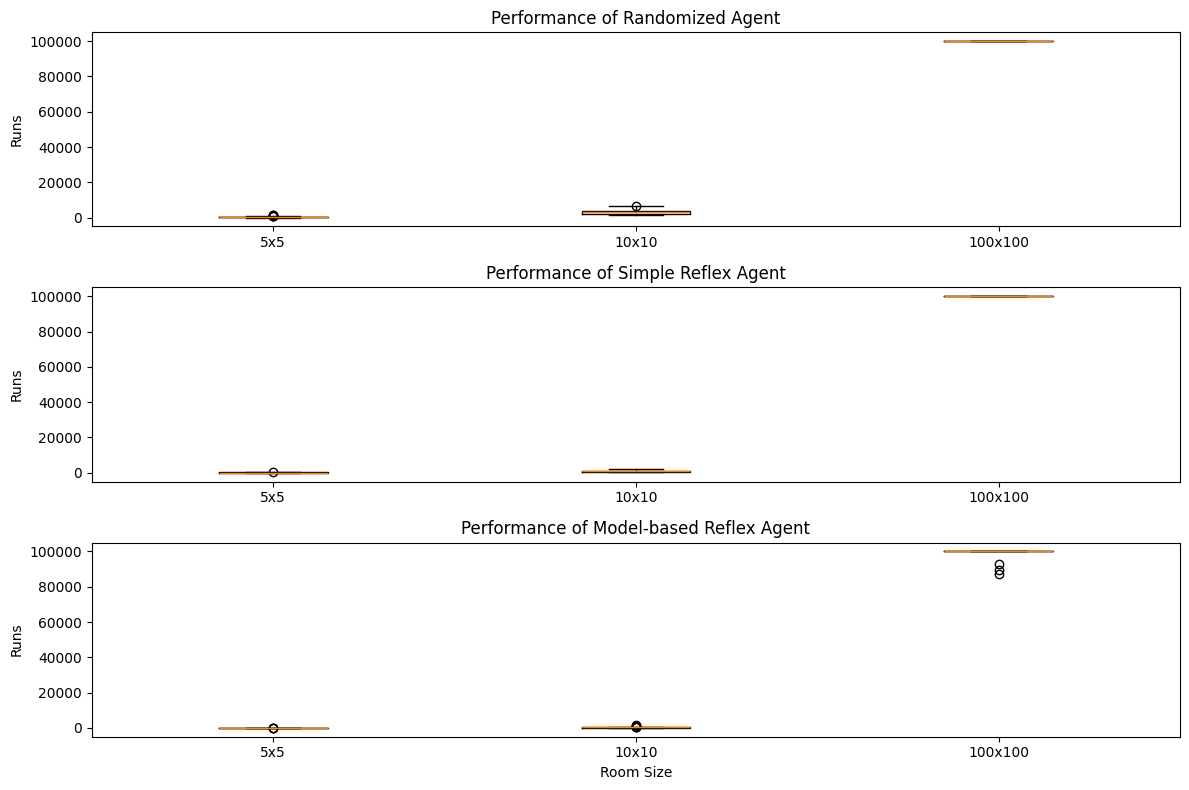

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, (agent_results, agent_name) in enumerate(zip([random_agent, simple_agent, model_agent],
                                                     ['Randomized Agent', 'Simple Reflex Agent', 'Model-based Reflex Agent'])):
    plt.subplot(3, 1, i+1)
    plt.boxplot(agent_results, labels=['5x5', '10x10', '100x100'])
    plt.title(f"Performance of {agent_name}")
    plt.ylabel("Runs")
plt.xlabel("Room Size")
plt.tight_layout()
plt.show()


# Line Plot : Average performance comparison of each Agent

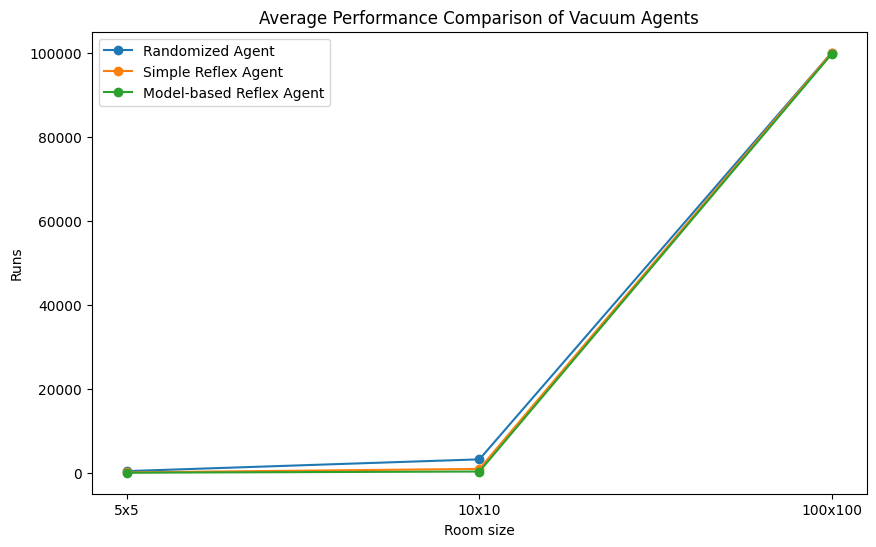

In [24]:
plt.figure(figsize=(10, 6))
for agent in ['Randomized Agent', 'Simple Reflex Agent', 'Model-based Reflex Agent']:
    plt.plot(df['Size'], df[agent], marker='o', linestyle='-', label=agent)
plt.xlabel("Room size")
plt.ylabel("Runs")
plt.title("Average Performance Comparison of Vacuum Agents")
plt.legend()
plt.show()


## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

1) If an agent were given a rectangular room with unknown size. First, the ramdom agent will perfrom the worse since it has no memory of visited tiles in the room and it could clean a tile that is already clean since the agent deciding the actions is ramdom. Second, the simple agent will perform slightly better since it's agent will only clean dirty tiles and it will avoid to move to directions (N,S,W,E) that is alrey on (bumpers are True). Lastly, the model-based agent will perform the best of the other two since the agent has acces to the internal state, this being a set of coordenates (x,y) of tiles that are already visited. In addition the agent will check if neighbor tiles are not a wall or not visited yet the by the robot, which it will minimize the number of visit of tiles and therfore clean the room in less steps.
2)If an agwnet were to be in an irregular shape. The random agent will be able to reach and clean irregular shapes, but it will take a longer number of steps to do so. On the other side, the relfex agent will be able to clean the regular shape (one room wihtout the hallway), and it will have difficulty cleaning and exploring the second room. Lastly, the model-based agent, will clean the two rooms and the hallway with no problme since the inner state allows it to explore all tiles within the given room(two rooms and hallway).
3)If the agent faces obstacles. The random agent will be bumping many times with the obsticles adding cost (more steps) to the implementation. On the other side, the reflex agent will avoid the obsticles but it will take a large amount of steps to finish cleaning the room. Lastly, the model-based agent will avoid all obsticles efficiently and its average time will not differ in comparison to without obsticles.